In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from kinematic_interpolation import kinematic_interpolation as ki
from typing import List, Tuple, Dict

In [4]:
DATA_PATH = os.path.join('..', 'data')

# load data into pandas dataframe
df = pd.read_csv(os.path.join(DATA_PATH, 'input_scenario_xy.csv'))
df.head()

,t,x,y,vx,vy,speed,heading
0,0.0,484850.605586,4.948439e+06,-0.00000,-0.000000,0.000000,187.0
1,5.0,484850.605586,4.948439e+06,-0.00000,-0.000000,0.000000,187.0
2,8.0,484850.605586,4.948439e+06,-0.00000,-0.000000,0.000000,187.0
3,11.0,484850.443978,4.948437e+06,-0.09945,-0.707622,0.714577,188.0
4,14.0,484849.723516,4.948434e+06,-0.32149,-1.392524,1.429153,193.0


In [ ]:
def latlon_to_local_xy(lat: np.ndarray, lon: np.ndarray) -> np.ndarray:
    """
    Convert lat/lon to local ENU coordinates (meters), centered at the first point.
    """
    if len(lat) == 0 or len(lon) == 0:
        raise ValueError("Latitude/Longitude arrays are empty.")
    if len(lat) != len(lon):
        raise ValueError("Latitude and Longitude must have the same length.")
    R = 6371000.0  # Earth radius (m)
    lat0 = np.deg2rad(lat[0])
    lon0 = np.deg2rad(lon[0])
    lat_r = np.deg2rad(lat)
    lon_r = np.deg2rad(lon)
    x = R * (lon_r - lon0) * np.cos(lat0)  # East
    y = R * (lat_r - lat0) # North
    return np.stack([x, y], axis=-1).astype(np.float64)

def detect_noisy_heading(record: Dict[str, list], angle_threshold: float = 30.0) -> np.ndarray:
    """
    Detects noisy heading angles in a trajectory record by comparing the reported heading
    with the direction of movement inferred from consecutive GPS points.

    Args:
        record: A dictionary containing trajectory data with keys 'Latitude', 'Longitude', and 'Heading'.
        angle_threshold: The maximum allowed difference in degrees between the reported heading and
                         the GPS-inferred heading before a point is considered noisy.

    Returns:
        A boolean numpy array where True indicates a noisy heading at that index.
    """
    lat = np.asarray(record.get("Latitude", []), dtype=np.float64)
    lon = np.asarray(record.get("Longitude", []), dtype=np.float64)
    heading = np.asarray(record.get("Heading", []), dtype=np.float64)

    if len(lat) < 2 or len(lon) < 2 or len(heading) < 2:
        # Not enough data to compare headings
        return np.array([False] * len(heading), dtype=bool)

    # Compute GPS-inferred headings between consecutive points
    dxy = latlon_to_local_xy(lat, lon)  # [T, 2]
    movement_vectors = np.diff(dxy, axis=0)  # [T-1, 2]
    movement_angles = np.arctan2(movement_vectors[:, 0], movement_vectors[:, 1])  # radians

    # Convert reported headings to radians
    reported_angles = np.deg2rad(heading[1:])  # skip first point, no movement vector

    # Compute absolute difference in angles, accounting for wrap-around at 2*pi
    angle_diffs = np.abs((movement_angles - reported_angles + np.pi) % (2 * np.pi) - np.pi)
    angle_diffs_deg = np.rad2deg(angle_diffs)
    # Prepend False for the first point (no movement vector)
    noisy = np.concatenate(([False], abs(angle_diffs_deg) > angle_threshold))
    return noisy

def clean_heading(heading_arr: np.ndarray, noisy: np.ndarray) -> np.ndarray:
    heading_rad = np.deg2rad(heading_arr)
    heading_2d = np.stack([np.cos(heading_rad), np.sin(heading_rad)], axis=-1)

    clean_heading_2d = heading_2d.copy()
    for i, is_clean in enumerate(~noisy):
        if is_clean:
            continue
        clean_heading_2d[i] = [np.nan] * 2  # because clean_heading_2d is an array of heading vectors

    # Replace the nans with interpolated values
    nans, x = np.isnan(clean_heading_2d[:,0]), lambda z: z.nonzero()[0]

    if nans.any():
        clean_heading_2d[nans] = np.vstack((np.interp(x(nans), x(~nans), clean_heading_2d[~nans,0]),
                                np.interp(x(nans), x(~nans), clean_heading_2d[~nans,1]))).transpose()
        
    return np.rad2deg(np.arctan2(clean_heading_2d[:,1],clean_heading_2d[:,0]))


def process_traj(record: Dict[str, list]) -> Dict[str, np.ndarray]:
    """
    Process a trajectory record to detect and clean noisy heading angles.

    Args:
        record: A dictionary containing trajectory data with keys 'Latitude', 'Longitude', and 'heading'.

    Returns:
        A dictionary with the same keys, where 'heading' has been cleaned.
    """
    noisy = detect_noisy_heading(record)
    clean_heading_arr = clean_heading(np.asarray(record.get("Heading", []), dtype=np.float64), noisy)

    # Return a new record with cleaned headings
    return {
        "Latitude": np.asarray(record.get("Latitude", []), dtype=np.float64),
        "Longitude": np.asarray(record.get("Longitude", []), dtype=np.float64),
        "Heading": clean_heading_arr
    }



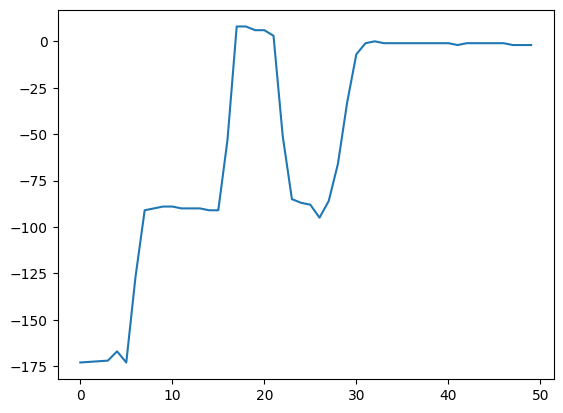

In [ ]:
lat, lon = ki.xy_to_latlon(df["x"].to_numpy(), df["y"].to_numpy())
rec = {"Latitude": lat, "Longitude": lon, "Heading": df["heading"].to_numpy()}

processed_traj = process_traj(rec)
lat_p, lon_p, heading_p = processed_traj["Latitude"], processed_traj["Longitude"], processed_traj["Heading"]

plt.plot(heading_p)


In [7]:
df['heading_p'] = heading_p
df['vx_p'] = df['speed'] * np.sin(np.deg2rad(df['heading_p']))
df['vy_p'] = df['speed'] * np.cos(np.deg2rad(df['heading_p']))


In [26]:
# df = df.rename(columns={'time': 't'})
df.to_csv(os.path.join(DATA_PATH, 'input_scenario_raw.csv'), index=False)

In [ ]:
import numpy as np
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod


# Constants
EPS = 1e-4
EARTH_RADIUS = 6371000  # in meters

# Define projection for lat/lon to x/y conversion
PROJECTION = pyproj.Proj(proj='utm', zone=15, ellps='WGS84')


def latlon_to_xy(lat, lon):
    """Converts latitude and longitude to Cartesian x, y coordinates."""
    x, y = PROJECTION(lon, lat)
    return x, y

def xy_to_latlon(x, y):
    """Converts Cartesian x, y coordinates back to latitude and longitude."""
    lon, lat = PROJECTION(x, y, inverse=True)
    return lat, lon

def calculate_velocity_components(speed, heading):
    """Calculates velocity components (vx, vy) from speed and heading."""
    radians = np.deg2rad(heading)
    vx = speed * np.sin(radians)
    vy = speed * np.cos(radians)
    return vx, vy

def prepare_data(df):
    """Prepares the dataframe by calculating velocity components and organizing columns."""
    df['vx'], df['vy'] = calculate_velocity_components(df['speed'], df['heading'])
    return df[['t', 'x', 'y', 'vx', 'vy', 'speed', 'heading']]

def kinematic_position(t, x1, v1, b, c):
    """Computes interpolated position using kinematic equations."""
    return x1 + v1 * t + (t**2) * b / 2 + (t**3) * c / 6

def kinematic_speed(t, v1, b, c):
    """Computes interpolated speed using kinematic equations."""
    return v1 + t * b + (t**2) * c / 2

def kinematic_acceleration(t, b, c):
    """Computes acceleration at a given time using kinematic equations."""
    print(b, t, c, b+ t * c)
    return b + t * c

# Defining an abstract class for interpolation strategies
class InterpolationStrategy(ABC):
    @abstractmethod
    def interpolate(self, time_from_start, x1, v1, x2, v2, t):
        pass

class LinearAccelerationInterpolation(InterpolationStrategy):
    # def interpolate(self, x1, v1, x2, v2, t1, t2, step):
    #     t = t2 - t1
    #     times = np.linspace(t1, t2, step+2)
    #     # print(t1, t2, step, times)
    #     time_from_start = times - t1
    #     print(f"Interpolating from t={t1} to t={t2} with step={step}")
    #     # Solve for coefficients in x-direction
    #     ax = np.array([[t**2 / 2, t**3 / 6], [t, t**2 / 2]])
    #     bx = [x2[0] - x1[0] - v1[0] * t, v2[0] - v1[0]]
    #     coef_x = np.linalg.solve(ax, bx)

    #     # Solve for coefficients in y-direction
    #     by = [x2[1] - x1[1] - v1[1] * t, v2[1] - v1[1]]
    #     coef_y = np.linalg.solve(ax, by)

    #     # Compute interpolated positions, velocities, and headings
    #     x = kinematic_position(time_from_start, x1[0], v1[0], coef_x[0], coef_x[1])
    #     y = kinematic_position(time_from_start, x1[1], v1[1], coef_y[0], coef_y[1])

    #     vx = kinematic_speed(time_from_start, v1[0], coef_x[0], coef_x[1])
    #     vy = kinematic_speed(time_from_start, v1[1], coef_y[0], coef_y[1])
    #     v = np.sqrt(vx**2 + vy**2)

    #     ax = kinematic_acceleration(time_from_start, coef_x[0], coef_x[1])
    #     ay = kinematic_acceleration(time_from_start, coef_y[0], coef_y[1])
    #     a = np.sqrt(ax**2 + ay**2)

    #     heading = np.arctan2(vy, vx + EPS)
    #     # heading = np.where(heading < 0, heading + 2 * np.pi, heading)
    #     heading = np.unwrap(heading)
    #     print(times[:-1])
    #     return pd.DataFrame({
    #         'x': x, 'y': y, 't': times, 'vx': vx, 'vy': vy,
    #         'speed': v, 'ax': ax, 'ay': ay,
    #         'acceleration': a, 'heading': np.rad2deg(heading)
    #     })


    def interpolate(self, x1, v1, a1, a2, t1, t2, step):
    
        """
        Interpolate segment using given endpoint acceleration components.
        a1, a2: 2-element arrays (ax, ay) at t1 and t2 respectively.
        """
        T = float(t2 - t1)
        if T <= 0:
            raise ValueError("t2 must be > t1")

        times = np.linspace(t1, t2, step + 2)
        t_rel = times[1:-1] - t1
        print(f"Interpolating from t={t1} to t={t2} with step={step}")

        # For each axis, acceleration is linear: a(t) = b + m * t_rel
        # endpoint values give b = a1, m = (a2 - a1) / T
        a1 = np.asarray(a1, dtype=float)
        a2 = np.asarray(a2, dtype=float)
        m = (a2 - a1) / T
        b = a1.copy()

        # integrate acceleration -> velocity: v(t) = v1 + b*t + 0.5*m*t^2
        vx = v1[0] + b[0] * t_rel + 0.5 * m[0] * t_rel**2
        vy = v1[1] + b[1] * t_rel + 0.5 * m[1] * t_rel**2
        speed = np.hypot(vx, vy)

        # integrate velocity -> position: x(t) = x1 + v1*t + 0.5*b*t^2 + (1/6)*m*t^3
        x = x1[0] + v1[0] * t_rel + 0.5 * b[0] * t_rel**2 + (1.0 / 6.0) * m[0] * t_rel**3
        y = x1[1] + v1[1] * t_rel + 0.5 * b[1] * t_rel**2 + (1.0 / 6.0) * m[1] * t_rel**3

        # acceleration components (linear)
        ax_comp = b[0] + m[0] * t_rel
        ay_comp = b[1] + m[1] * t_rel
        accel_mag = np.hypot(ax_comp, ay_comp)

        heading = np.rad2deg(np.unwrap(np.arctan2(vy, vx + EPS)))
        return pd.DataFrame({
            'x': x, 'y': y, 't': times, 'vx': vx, 'vy': vy,
            'speed': speed, 'ax': ax_comp, 'ay': ay_comp,
            'acceleration': accel_mag, 'heading': heading
        })

# TODO: Implement the ConstantAccelerationInterpolation class
class ConstantAccelerationInterpolation(InterpolationStrategy):
    def interpolate(self, time_from_start, x1, v1, x2, v2, t):
        # Implementation for constant acceleration interpolation
        pass


def timestamp_to_seconds(timestamps):
    """Converts timestamps to seconds relative to the first timestamp."""
    timestamps = pd.to_datetime(timestamps)
    start_time = timestamps[0]
    journey_time = [(ts - start_time).total_seconds() for ts in timestamps]
    return journey_time, start_time

def interpolate_trajectory(df, strategy: InterpolationStrategy, step=100):
    """Performs interpolation for the full trajectory using the specified strategy."""
    interpolated_points = pd.DataFrame()

    vx = df['vx'].astype(np.float64)
    vy = df['vy'].astype(np.float64)
    t  = df['t'].astype(np.float64)

    # forward diff for all rows except the last
    dt_f = t.shift(-1) - t
    ax_f = (vx.shift(-1) - vx) / dt_f
    ay_f = (vy.shift(-1) - vy) / dt_f

    # last row: use backward difference
    if len(df) >= 2:
        dt_last = t.iloc[-1] - t.iloc[-2]
        if dt_last != 0.0:
            ax_f.iloc[-1] = (vx.iloc[-1] - vx.iloc[-2]) / dt_last
            ay_f.iloc[-1] = (vy.iloc[-1] - vy.iloc[-2]) / dt_last
        else:
            ax_f.iloc[-1] = 0.0
            ay_f.iloc[-1] = 0.0

    # guard against inf/nan and store
    df['ax'] = ax_f.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float64)
    df['ay'] = ay_f.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float64)

    for i in range(len(df) - 1):
        segment = df.iloc[i:i+2][['x', 'y', 't', 'vx', 'vy', 'speed', 'ax', 'ay', 'heading']].to_numpy(dtype=np.float64)
     
        t_start = df.iloc[i]['t']
        t_end = df.iloc[i+1]['t']
        
        
        # Generate multiple intermediate time steps between t_start and t_end
        times = np.arange(t_start, t_end, step)
        # print(times)
        time_from_start= times - t_start

        # interpolated_segment = strategy.interpolate(time_from_start, segment[0, :2], segment[0, 3:5], segment[1, :2], segment[1, 3:5], t_end - t_start)
        # interpolated_segment = strategy.interpolate(segment[0, :2], segment[0, 3:5], segment[1, :2], segment[1, 3:5], t_start, t_end, step)
        interpolated_segment = strategy.interpolate(segment[0, :2], segment[0, 3:5], segment[0, 6:8], segment[1, 6:8], t_start, t_end, step)

        # print(interpolated_segment)
        interpolated_points = pd.concat([interpolated_points, interpolated_segment], ignore_index=True)

    return interpolated_points

def visualize_results(original_df, interpolated_df):
    """Visualizes the original and interpolated trajectory, speed, heading, and acceleration components."""
    plt.figure(figsize=(10, 6))
    plt.plot(original_df['x'], original_df['y'], 'bo-', alpha = 0.3, label='Original Points')
    plt.scatter(interpolated_df['x'], interpolated_df['y'], c='red', label='Interpolated Points')

    # Add heading arrows for original points
    arrow_scale = 2  # Adjust for visual clarity
    orig_u = np.sin(np.deg2rad(original_df['heading'])) * arrow_scale
    orig_v = np.cos(np.deg2rad(original_df['heading'])) * arrow_scale
    plt.quiver(original_df['x'], original_df['y'], orig_u, orig_v, color='blue', angles='xy', scale_units='xy', scale=1, width=0.005, label='Original Heading')

    # Add heading arrows for interpolated points
    interp_u = np.sin(np.deg2rad(interpolated_df['heading'])) * arrow_scale
    interp_v = np.cos(np.deg2rad(interpolated_df['heading'])) * arrow_scale
    plt.quiver(interpolated_df['x'], interpolated_df['y'], interp_u, interp_v, color='red', angles='xy', scale_units='xy', scale=1, width=0.005, label='Interpolated Heading')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Kinematic Interpolation of Trajectory')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(original_df['t'], original_df['speed'], 'bo-', label='Original Speed')
    plt.plot(interpolated_df['t'], interpolated_df['speed'], 'ro-', label='Interpolated Speed')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed')
    plt.title('Speed Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(original_df['t'], original_df['heading'], 'bo-', label='Original Heading')
    plt.plot(interpolated_df['t'], interpolated_df['heading'], 'ro-', label='Interpolated Heading')
    plt.xlabel('Time (s)')
    plt.ylabel('heading')
    plt.title('Heading Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot acceleration magnitude vs time for interpolated points
    plt.figure(figsize=(10, 6))
    if 'acceleration' in original_df.columns:
        plt.plot(original_df['t'], original_df['acceleration'], 'bo-', label='Original Acceleration')
    plt.plot(interpolated_df['t'], interpolated_df['acceleration'], 'ro-', label='Interpolated Acceleration')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration Magnitude')
    plt.title('Acceleration Magnitude Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute acceleration components for original and interpolated data
    def compute_accel_components(df, accel_col, heading_col):
        ax = df[accel_col] * np.sin(np.deg2rad(df[heading_col]))
        ay = df[accel_col] * np.cos(np.deg2rad(df[heading_col]))
        return ax, ay

    # Acceleration X
    plt.figure(figsize=(10, 6))
    if 'acceleration' in original_df.columns:
        ax_orig, _ = compute_accel_components(original_df, 'acceleration', 'heading')
        plt.plot(original_df['t'], ax_orig, 'bo-', label='Original Acceleration X')
    ax_interp, _ = compute_accel_components(interpolated_df, 'acceleration', 'heading')
    plt.plot(interpolated_df['t'], ax_interp, 'ro-', label='Interpolated Acceleration X')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration X')
    plt.title('Acceleration X Component Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Acceleration Y
    plt.figure(figsize=(10, 6))
    if 'acceleration' in original_df.columns:
        _, ay_orig = compute_accel_components(original_df, 'acceleration', 'heading')
        plt.plot(original_df['t'], ay_orig, 'bo-', label='Original Acceleration Y')
    _, ay_interp = compute_accel_components(interpolated_df, 'acceleration', 'heading')
    plt.plot(interpolated_df['t'], ay_interp, 'ro-', label='Interpolated Acceleration Y')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration Y')
    plt.title('Acceleration Y Component Interpolation')
    plt.legend()
    plt.grid(True)
    plt.show()


In [138]:
# ...existing code...
# forward-difference accelerations (last index uses backward difference)
vx = df['vx'].astype(float)
vy = df['vy'].astype(float)
t  = df['t'].astype(float)

# forward diff for all rows except the last
dt_f = t.shift(-1) - t
ax_f = (vx.shift(-1) - vx) / dt_f
ay_f = (vy.shift(-1) - vy) / dt_f

# last row: use backward difference
if len(df) >= 2:
    dt_last = t.iloc[-1] - t.iloc[-2]
    if dt_last != 0.0:
        ax_f.iloc[-1] = (vx.iloc[-1] - vx.iloc[-2]) / dt_last
        ay_f.iloc[-1] = (vy.iloc[-1] - vy.iloc[-2]) / dt_last
    else:
        ax_f.iloc[-1] = 0.0
        ay_f.iloc[-1] = 0.0

# guard against inf/nan and store
df['ax'] = ax_f.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(float)
df['ay'] = ay_f.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(float)
# ...existing code...

C:\Users\jayap015.AD\AppData\Local\Temp\ipykernel_19152\1399364816.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ax'] = ax_f.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(float)


In [21]:
df = pd.read_csv('./../data/sample.csv')
df.rename(columns={'Unnamed: 0': 't'}, inplace=True)

In [22]:
df['speed'] = (df['vx']**2 + df['vy']**2)**0.5

In [126]:
df['vy'] = df['speed'] * np.sin(np.deg2rad(df['heading']))
df['vx'] = df['speed'] * np.cos(np.deg2rad(df['heading']))

C:\Users\jayap015.AD\AppData\Local\Temp\ipykernel_19152\1191839528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vy'] = df['speed'] * np.sin(np.deg2rad(df['heading']))
C:\Users\jayap015.AD\AppData\Local\Temp\ipykernel_19152\1191839528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vx'] = df['speed'] * np.cos(np.deg2rad(df['heading']))


In [151]:
df.iloc[250:260]

,t,x,y,vx,vy,speed,heading,ax,ay
250,250,596.38000,187.92450,13.651846,0.000000,13.651846,0.00000,-0.106480,0.000000
251,251,609.92330,187.68810,13.545366,0.000000,13.545366,0.00000,-0.106482,0.000000
252,252,623.36010,187.45355,13.438884,0.000000,13.438884,0.00000,-0.106480,0.000000
253,253,636.69050,187.22087,13.332404,0.000000,13.332404,0.00000,-0.106483,0.000000
254,254,649.91437,186.99005,13.225921,0.000000,13.225921,0.00000,-0.106482,0.000000
255,255,663.03180,186.76108,13.119439,0.000000,13.119439,0.00000,-0.000222,-0.076325
256,256,676.15030,186.60843,13.119217,-0.076325,13.119439,-0.33333,-0.000665,-0.076325
257,257,689.26953,186.53210,13.118552,-0.152649,13.119440,-0.66667,-0.001111,-0.076317
258,258,702.38900,186.53210,13.117441,-0.228966,13.119439,-1.00000,0.107585,0.075078
259,259,715.61470,186.45515,13.225026,-0.153888,13.225921,-0.66667,0.107151,0.076325


In [157]:
result.iloc[750:770]

,x,y,t,vx,vy,speed,ax,ay,acceleration,heading
750,596.380000,187.924500,250.0,13.651846,0.000000,13.651846,-0.106480,0.000000,0.106480,0.000000
751,603.192613,187.924500,250.5,13.598606,0.000000,13.598606,-0.106481,0.000000,0.106481,0.000000
752,609.978606,187.924500,251.0,13.545365,0.000000,13.545365,-0.106482,0.000000,0.106482,0.000000
753,609.923300,187.688100,251.0,13.545366,0.000000,13.545366,-0.106482,0.000000,0.106482,0.000000
754,616.682673,187.688100,251.5,13.492125,0.000000,13.492125,-0.106481,0.000000,0.106481,0.000000
755,623.415425,187.688100,252.0,13.438885,0.000000,13.438885,-0.106480,0.000000,0.106480,0.000000
756,623.360100,187.453550,252.0,13.438884,0.000000,13.438884,-0.106480,0.000000,0.106480,0.000000
757,630.066232,187.453550,252.5,13.385643,0.000000,13.385643,-0.106481,0.000000,0.106481,0.000000
758,636.745743,187.453550,253.0,13.332402,0.000000,13.332402,-0.106483,0.000000,0.106483,0.000000
759,636.690500,187.220870,253.0,13.332404,0.000000,13.332404,-0.106483,0.000000,0.106483,0.000000


In [147]:
# diagnostic — run for one segment index i
i = 250  # pick a segment index to inspect
row0 = df.iloc[i]
row1 = df.iloc[i+1]
seg = df.iloc[i:i+2][['x','y','t','vx','vy','speed','ax','ay']].to_numpy()
t1, t2 = row0['t'], row1['t']
T = t2 - t1
# reproduce what your interpolate() does for that segment
times_abs = np.linspace(t1, t2, 1+2)   # use same args as your code for quick check
t_rel = times_abs - t1

# solve for b,c (x axis)
A = np.array([[T**2/2, T**3/6], [T, T**2/2]], dtype=float)
bx = [seg[1,0] - seg[0,0] - seg[0,3]*T, seg[1,3] - seg[0,3]]   # x pos/vel deltas (watch index order)
by = [seg[1,1] - seg[0,1] - seg[0,4]*T, seg[1,4] - seg[0,4]]
b_x, c_x = np.linalg.solve(A, bx)
b_y, c_y = np.linalg.solve(A, by)

# analytic component accel and your function's accel
ax_analytic = b_x + c_x * t_rel
ay_analytic = b_y + c_y * t_rel

# call your function to get the values it returns for that segment (if available)
seg_df = LinearAccelerationInterpolation().interpolate(seg[0,:2], seg[0,3:5], seg[0,6:8], seg[1,6:8], t1, t2, step=1)
print("times_rel:", t_rel)
print("ax_analytic:", ax_analytic)
print("ay_analytic:", ay_analytic)
print("ax_from_df:", seg_df['ax'].to_numpy())
print("ay_from_df:", seg_df['ay'].to_numpy())
print("diff ax:", ax_analytic - seg_df['ax'].to_numpy())
print("diff ay:", ay_analytic - seg_df['ay'].to_numpy())

Interpolating from t=250.0 to t=251.0 with step=1
times_rel: [0.  0.5 1. ]
ax_analytic: [-0.43831702 -0.10648022  0.22535658]
ay_analytic: [-1.4184  0.      1.4184]
ax_from_df: [-0.10648022 -0.10648122 -0.10648222]
ay_from_df: [0. 0. 0.]
diff ax: [-3.31836800e-01  1.00010948e-06  3.31838801e-01]
diff ay: [-1.4184  0.      1.4184]


In [146]:
seg

array([[ 5.96380000e+02,  1.87924500e+02,  2.50000000e+02,
         1.36518462e+01,  0.00000000e+00, -1.06480218e-01,
         0.00000000e+00],
       [ 6.09923300e+02,  1.87688100e+02,  2.51000000e+02,
         1.35453660e+01,  0.00000000e+00, -1.06482218e-01,
         0.00000000e+00]])

C:\Users\jayap015.AD\AppData\Local\Temp\ipykernel_19152\1804880784.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ax'] = ax_f.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float64)
C:\Users\jayap015.AD\AppData\Local\Temp\ipykernel_19152\1804880784.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ay'] = ay_f.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(np.float64)


   t    x    y   vx   vy  speed    heading   ax   ay
0  0  0.0  0.0 -0.0  0.0    0.0  91.000000  0.0  0.0
1  1  0.0  0.0 -0.0  0.0    0.0  90.990099  0.0  0.0
[[ 0.         0.         0.        -0.         0.         0.
   0.         0.        91.       ]
 [ 0.         0.         1.        -0.         0.         0.
   0.         0.        90.9900995]]
Interpolating from t=0.0 to t=1.0 with step=1
   t    x    y   vx   vy  speed    heading   ax   ay
1  1  0.0  0.0 -0.0  0.0    0.0  90.990099  0.0  0.0
2  2  0.0  0.0 -0.0  0.0    0.0  90.980199  0.0  0.0
[[ 0.          0.          1.         -0.          0.          0.
   0.          0.         90.9900995 ]
 [ 0.          0.          2.         -0.          0.          0.
   0.          0.         90.98019897]]
Interpolating from t=1.0 to t=2.0 with step=1
   t    x    y   vx   vy  speed    heading   ax   ay
2  2  0.0  0.0 -0.0  0.0    0.0  90.980199  0.0  0.0
3  3  0.0  0.0 -0.0  0.0    0.0  90.970298  0.0  0.0
[[ 0.          0.        

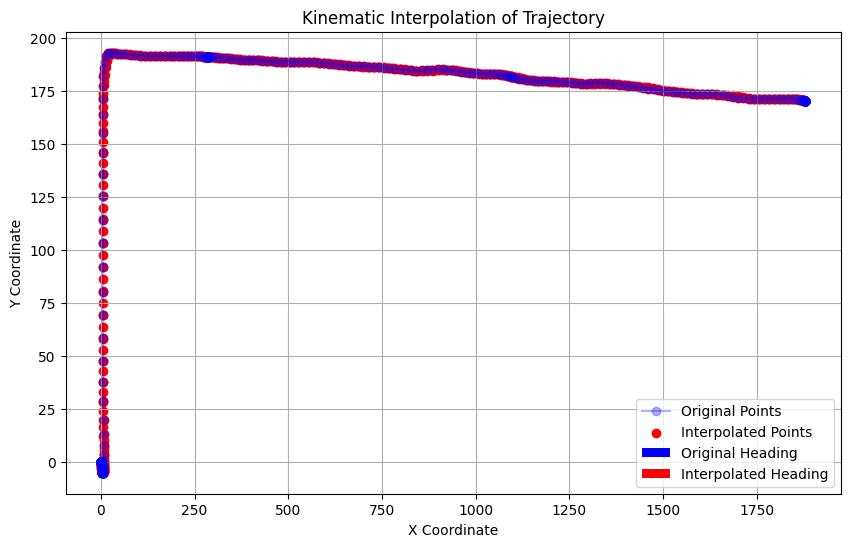

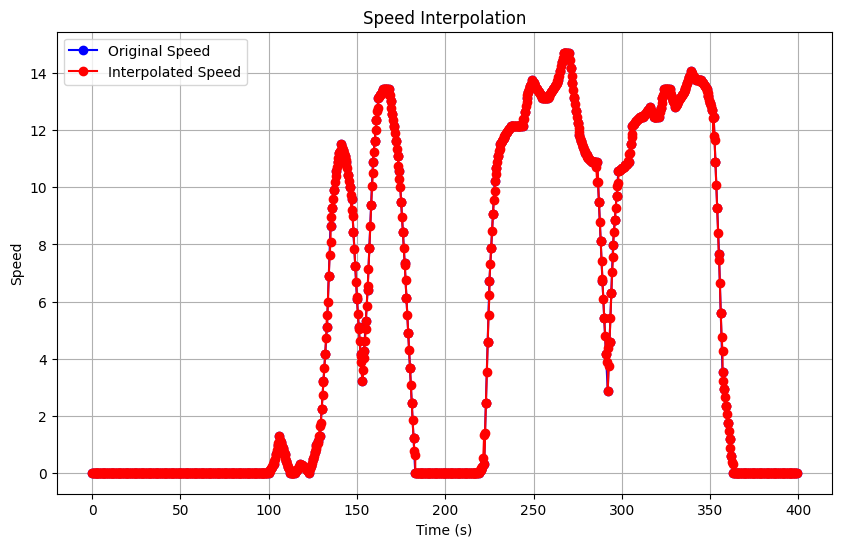

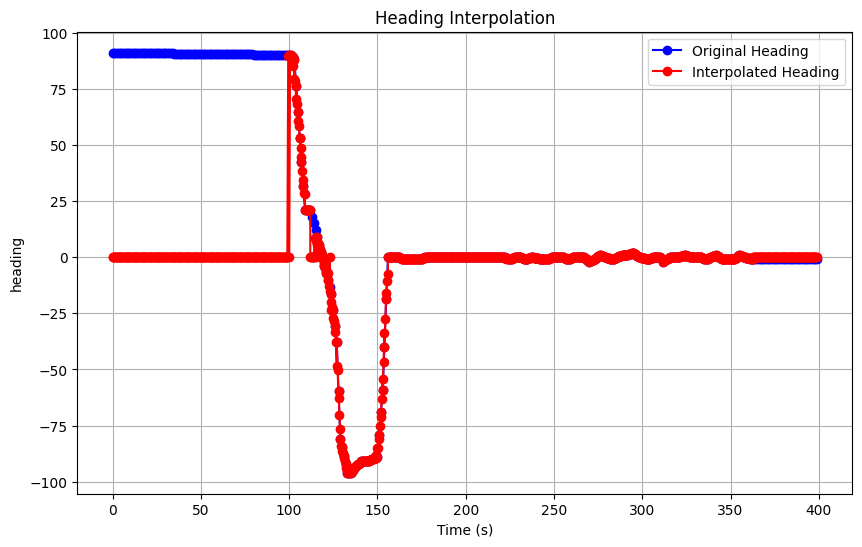

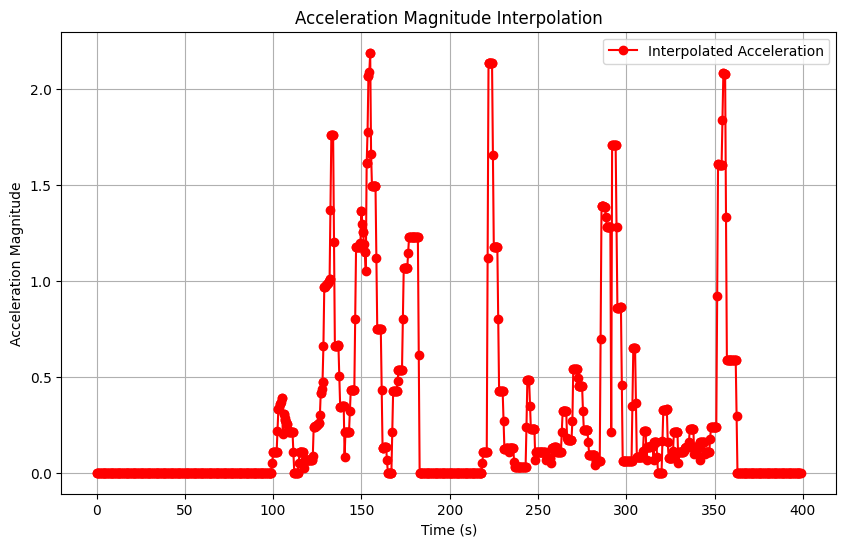

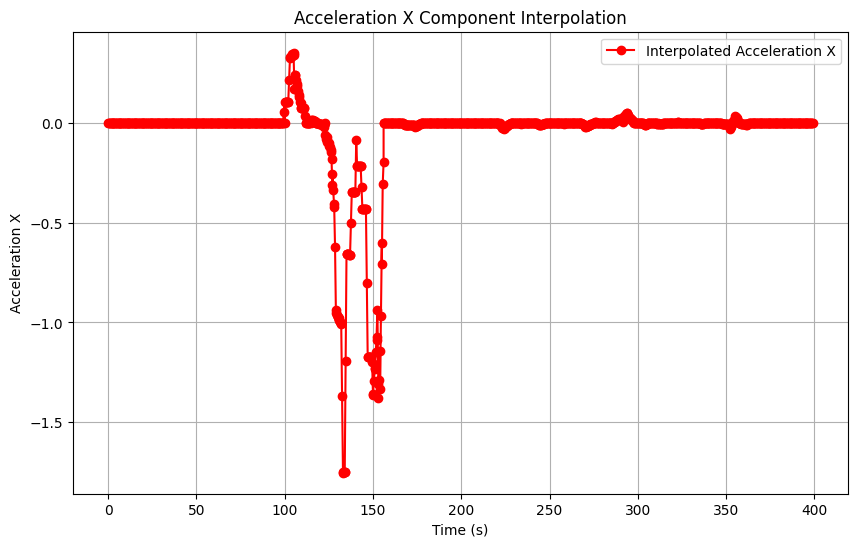

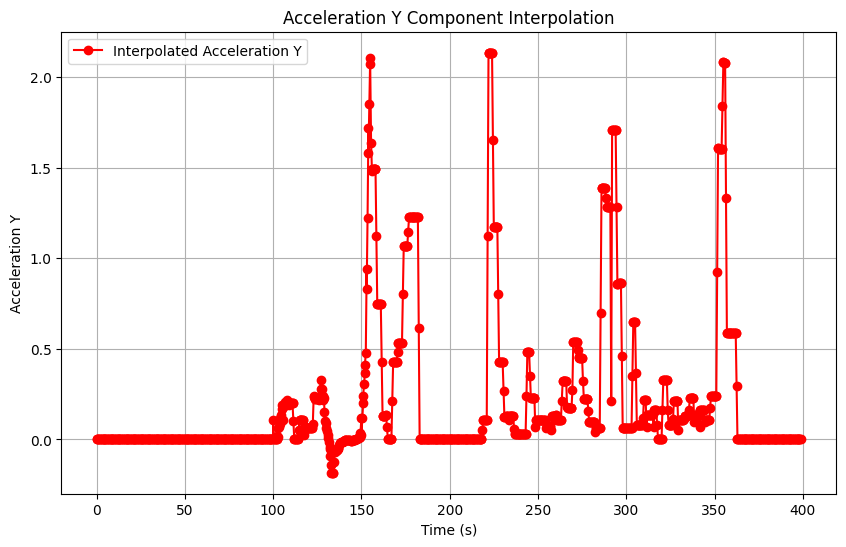

In [159]:
# Prepare data by calculating velocity components
# df = prepare_data(df)
df_ = df.iloc[:400]
strategy = LinearAccelerationInterpolation()
num_interpolations = 1  # Adjust this value as needed
result = interpolate_trajectory(df_, strategy, num_interpolations)
visualize_results(df_, result)
# # Perform full interpolation on the trajectory
# interpolated_points = ki.interpolate_trajectory(df)

# # Convert interpolated x/y back to lat/lon
# interpolated_latlon = [ki.xy_to_latlon(row['x'], row['y']) for _, row in interpolated_points.iterrows()]
# interpolated_points['lat'], interpolated_points['lon'] = zip(*interpolated_latlon)

# # Visualize the results
# ki.visualize_results(df, interpolated_points)


Interpolating from t=0.0 to t=1.0 with step=1
Interpolating from t=1.0 to t=2.0 with step=1
Interpolating from t=2.0 to t=3.0 with step=1
Interpolating from t=3.0 to t=4.0 with step=1
Interpolating from t=4.0 to t=5.0 with step=1
Interpolating from t=5.0 to t=6.0 with step=1
Interpolating from t=6.0 to t=7.0 with step=1
Interpolating from t=7.0 to t=8.0 with step=1
Interpolating from t=8.0 to t=9.0 with step=1
Interpolating from t=9.0 to t=10.0 with step=1
Interpolating from t=10.0 to t=11.0 with step=1
Interpolating from t=11.0 to t=12.0 with step=1
Interpolating from t=12.0 to t=13.0 with step=1
Interpolating from t=13.0 to t=14.0 with step=1
Interpolating from t=14.0 to t=15.0 with step=1
Interpolating from t=15.0 to t=16.0 with step=1
Interpolating from t=16.0 to t=17.0 with step=1
Interpolating from t=17.0 to t=18.0 with step=1
Interpolating from t=18.0 to t=19.0 with step=1
Interpolating from t=19.0 to t=20.0 with step=1
Interpolating from t=20.0 to t=21.0 with step=1
Interpolati

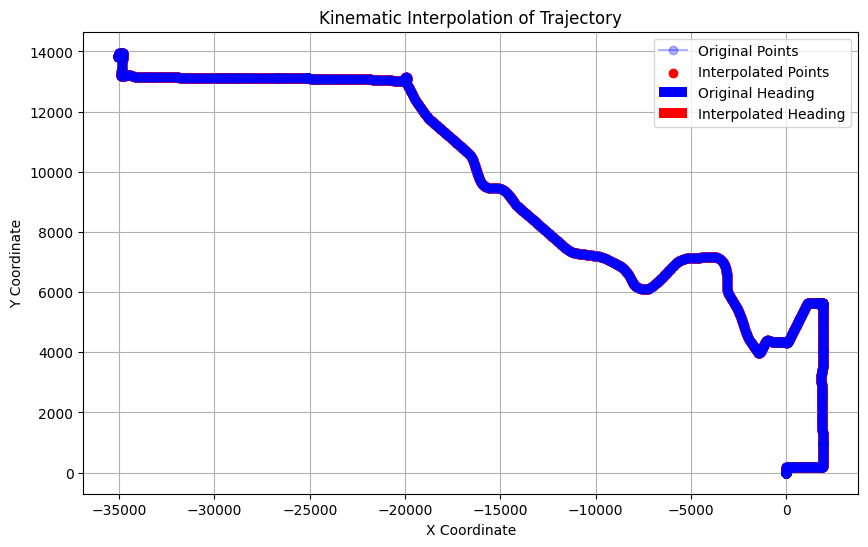

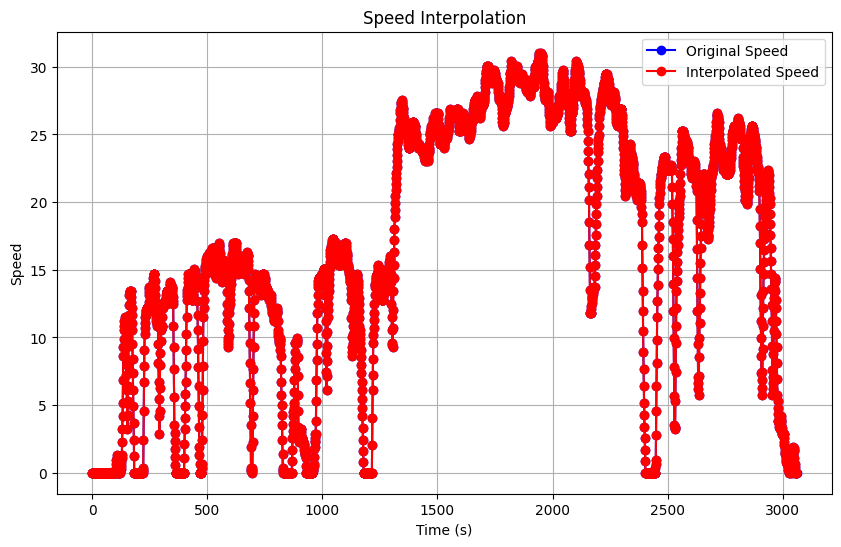

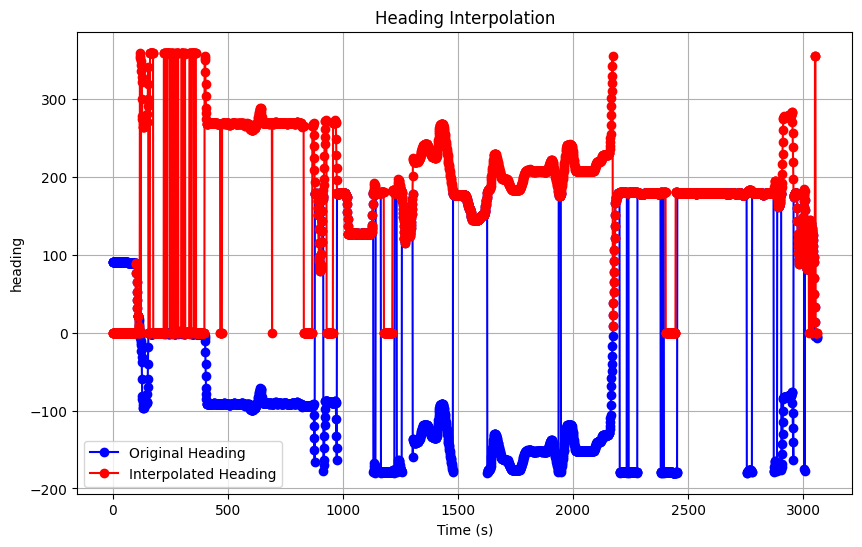

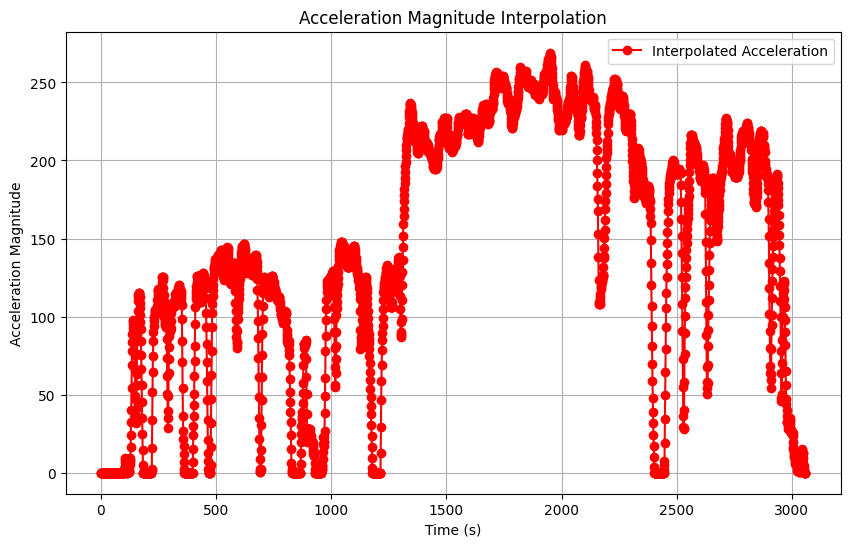

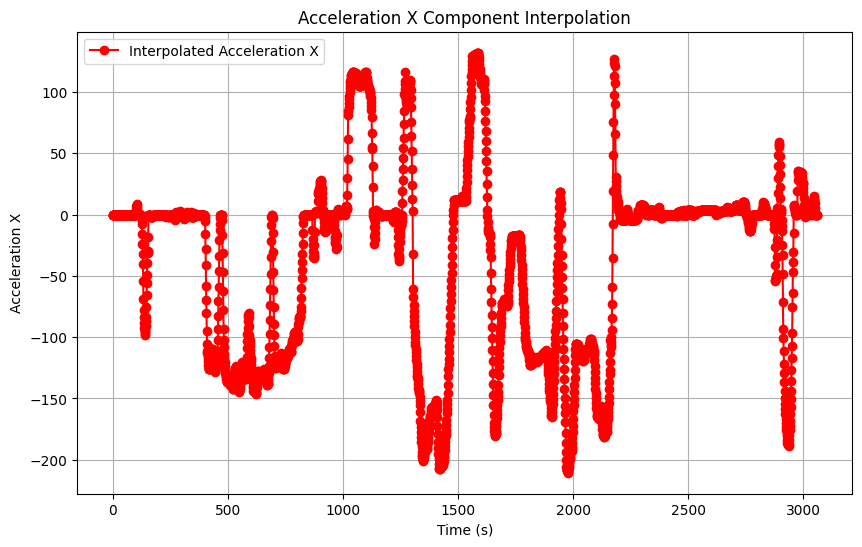

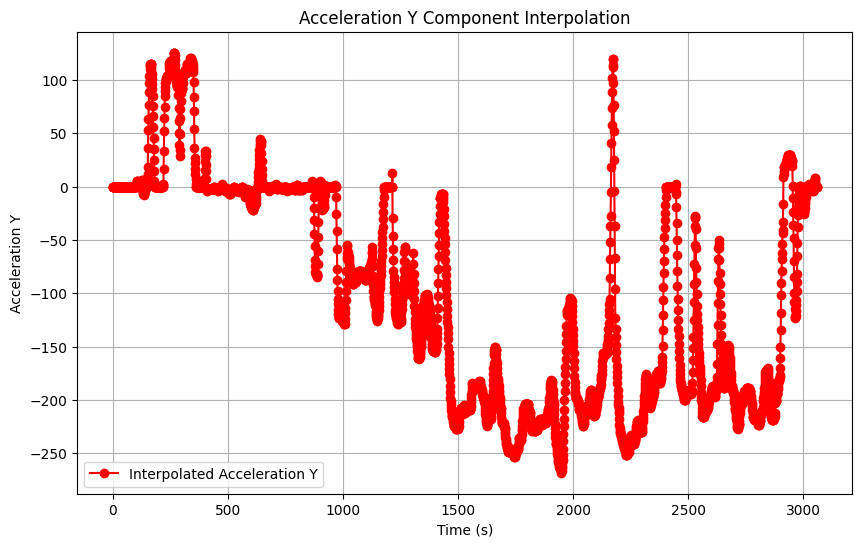

In [31]:
# Prepare data by calculating velocity components
df = prepare_data(df)
strategy = LinearAccelerationInterpolation()
num_interpolations = 1  # Adjust this value as needed
result = interpolate_trajectory(df, strategy, num_interpolations)
visualize_results(df, result)
# # Perform full interpolation on the trajectory
# interpolated_points = ki.interpolate_trajectory(df)

# # Convert interpolated x/y back to lat/lon
# interpolated_latlon = [ki.xy_to_latlon(row['x'], row['y']) for _, row in interpolated_points.iterrows()]
# interpolated_points['lat'], interpolated_points['lon'] = zip(*interpolated_latlon)

# # Visualize the results
# ki.visualize_results(df, interpolated_points)


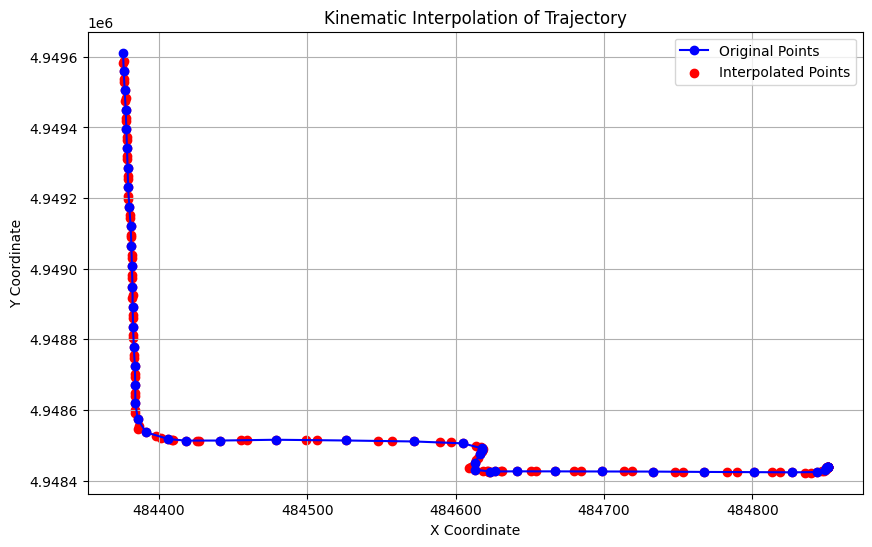

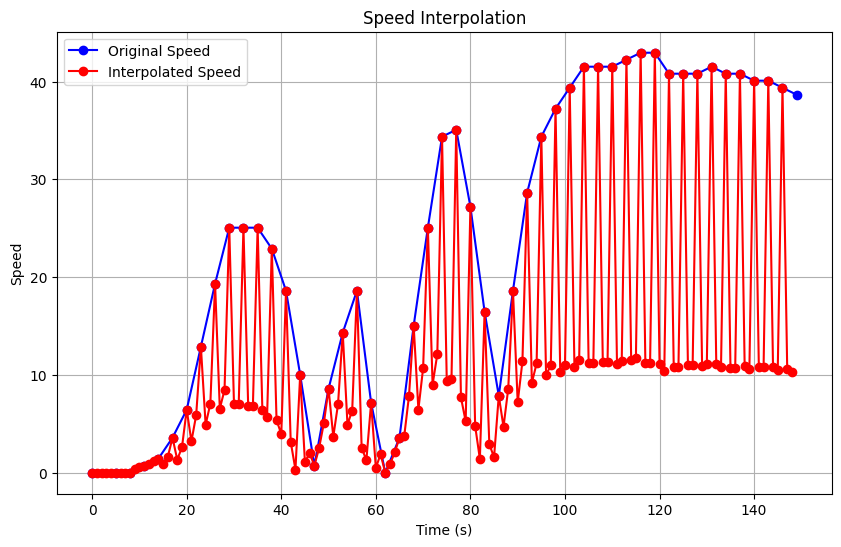

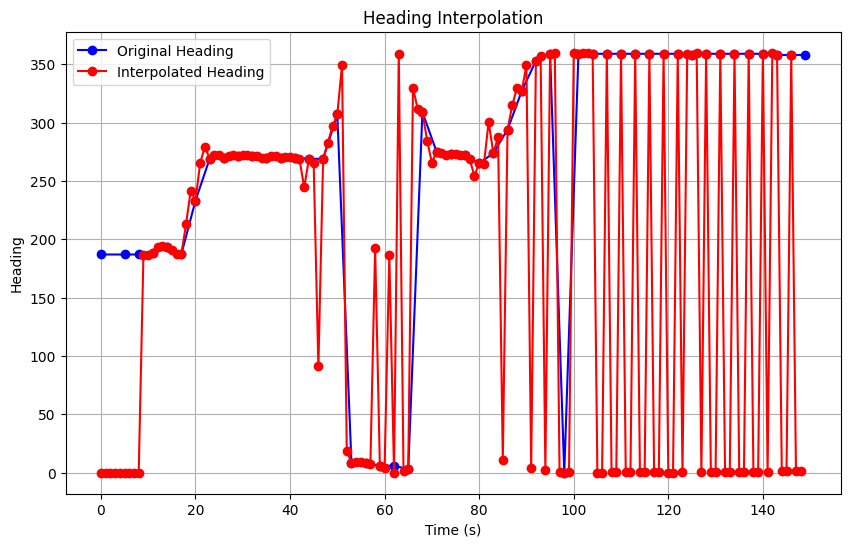

In [10]:
# Prepare data by calculating velocity components
df = prepare_data(df)

# Perform full interpolation on the trajectory
interpolated_points = interpolate_trajectory(df)

# Convert interpolated x/y back to lat/lon
interpolated_latlon = [xy_to_latlon(row['x'], row['y']) for _, row in interpolated_points.iterrows()]
interpolated_points['lat'], interpolated_points['lon'] = zip(*interpolated_latlon)

# Visualize the results
ki.visualize_results(df, interpolated_points)


In [7]:
# Prepare data by calculating velocity components
df = ki.prepare_data(df)

# Perform full interpolation on the trajectory
interpolated_points = ki.interpolate_trajectory(df)

# Convert interpolated x/y back to lat/lon
interpolated_latlon = [ki.xy_to_latlon(row['x'], row['y']) for _, row in interpolated_points.iterrows()]
interpolated_points['lat'], interpolated_points['lon'] = zip(*interpolated_latlon)

# Visualize the results
ki.visualize_results(df, interpolated_points)


TypeError: interpolate_trajectory() missing 1 required positional argument: 'strategy'